<a href="https://colab.research.google.com/github/Salah-Mo-hammed/Prediction_of_Product_Sales/blob/main/Mock_Belt_Exam_ML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import basic libraires
from sklearn import set_config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import preproccesing libraries
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
# import models , metrices ,and GridSearchCv
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import  accuracy_score, recall_score, precision_score,classification_report
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier ,RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
fpath="/content/drive/MyDrive/AXSOSACADEMY/AXSOSACADEMY/02-IntroML/Week07/Data/smoke_detection_iot_BELT.csv"
smoker_df=pd.read_csv(fpath)
smoker_df=smoker_df.drop(columns=['Unnamed: 0'],axis=1)
smoker_df.head()

,UTC,Temperature[C],Humidity[%],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1655127852,19.117,56.52,400,13314.0,High,med,1.71,1.78,11.77,1.835,0.041,1928,0
1,1654777894,NaN,55.78,400,12889.0,Low,High,1.71,1.78,11.79,1.838,0.042,22541,1
2,1654785729,26.160,51.93,406,12989.0,Low,High,1.95,2.03,13.43,2.095,0.047,20717,1
3,1654773681,26.960,52.51,577,NaN,Low,High,2.31,2.40,15.91,2.481,0.056,22852,1
4,1654779348,19.860,NaN,400,12910.0,Low,High,1.72,1.79,11.85,1.848,0.042,14193,1


## Data Cleaning

In [ ]:
print(smoker_df.duplicated().sum()) # zero duplicates
print('\n')
print(smoker_df.isna().sum().sum()) # 44469 nan
# smoker_df.isna().sum() # temp c (float64) : 18790 ,,Raw H2 (float64):	15031 , Humidity[%]: 10648
# note : all are numarics , except Raw Ethanol , Pressure[hPa]
# so nan are just in numamric types

0


44469


In [ ]:
smoker_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62633 entries, 0 to 62632
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UTC             62633 non-null  int64  
 1   Temperature[C]  43843 non-null  float64
 2   Humidity[%]     51985 non-null  float64
 3   eCO2[ppm]       62633 non-null  int64  
 4   Raw H2          47602 non-null  float64
 5   Raw Ethanol     62633 non-null  object 
 6   Pressure[hPa]   62633 non-null  object 
 7   PM1.0           62633 non-null  float64
 8   PM2.5           62633 non-null  float64
 9   NC0.5           62633 non-null  float64
 10  NC1.0           62633 non-null  float64
 11  NC2.5           62633 non-null  float64
 12  CNT             62633 non-null  int64  
 13  Fire Alarm      62633 non-null  int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 6.7+ MB


In [ ]:
#  temp c (float64) : 18790 ,,Raw H2 (float64):	15031
smoker_df['Temperature[C]']=smoker_df['Temperature[C]'].fillna(-1)
smoker_df['Raw H2']=smoker_df['Raw H2'].fillna(-1)
smoker_df['Humidity[%]']=smoker_df['Humidity[%]'].fillna(-1)
print(smoker_df.isna().sum().sum())

0


In [ ]:
test_cats=smoker_df.select_dtypes(include='object').columns

test_nums=smoker_df.select_dtypes(include='number').columns
for col in test_cats:
  print(col)
  print(smoker_df[col].value_counts())
  print('\n')

# Raw Ethanol (Very Low , Low , Medium , High ) : very low => Very Low ;/// low => Low ;/// medium => Medium ;/// high => High
# Pressure[hPa] (Low , Med , High) : low => Low  ;/// med => Med ;/// high => High
smoker_df['Raw Ethanol']=smoker_df['Raw Ethanol'].replace({'very low':'Very Low','low':'Low','medium':'Medium','high':'High'})
smoker_df['Pressure[hPa]']=smoker_df['Pressure[hPa]'].replace({'low':'Low','med':'Med','high':'High'})

Raw Ethanol
Raw Ethanol
Low         35022
Medium      16898
High         8879
Very Low     1834
Name: count, dtype: int64


Pressure[hPa]
Pressure[hPa]
High    49991
Med     11488
Low      1154
Name: count, dtype: int64




In [ ]:
smoker_df.describe()
# Humidity[%] min cannot be -60% , eCO2[ppm] max  60000.00000  ,,   (PM1.0	PM2.5	NC0.5	NC1.0	NC2.5)  14333.690000	45432.260000	61482.030000	51914.680000	30026.438000	24993.000000
# Humidity[%]  نسبة الرطوبة كيف -60%
# eCO2[ppm] : co2 in air (part of million) is it possible to have max 60000.00000?
# PM1.0	PM2.5	NC0.5	NC1.0	NC2.5 :  تركيز عدد ودقة الجسيمات في 0.1 لتر هوا

eCO2_outlier=smoker_df['eCO2[ppm]']==60000.000000
smoker_df[eCO2_outlier] # this to show all valiables that there eco2 have value 60000
smoker_df.loc[17076,'eCO2[ppm]']=smoker_df['eCO2[ppm]'].mean() # this to replace the index 17076 in col co2 with the mean
smoker_df.loc[42673,'eCO2[ppm]']=smoker_df['eCO2[ppm]'].mean()
#  i dont know about the rest , if they are outlies , or the problem in min (in -60%) , or is it ok

## Visualizing Data:

#### EDA Functions

In [ ]:
"""UNIVARIATE PLOTTING FUNCTIONS FOR EDA"""
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


# TO DO: add the new print statements from explore_categorical
def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


In [ ]:
"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y='rating',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y,
                           figsize=(6,4),
                           ):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax,scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

### Univariate:

/tmp/ipython-input-54-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


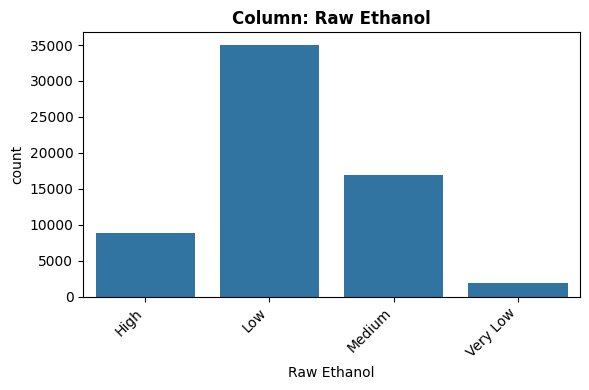

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Low' occurs 35022 times (55.92%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Raw Ethanol'}, xlabel='Raw Ethanol', ylabel='count'>)

In [ ]:
target='Raw Ethanol'
explore_categorical(smoker_df,target)

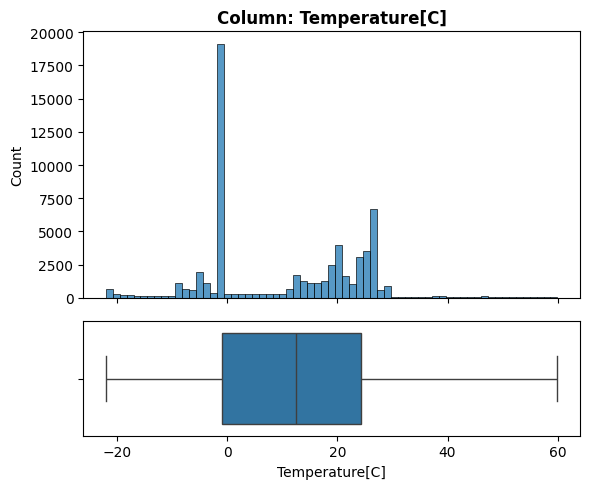

- NaN's Found: 0 (0.0%)
- Unique Values: 17293
- Most common value: '-1.0' occurs 18790 times (30.0%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Temperature[C]'}, xlabel='Temperature[C]', ylabel='Count'>,
        <Axes: xlabel='Temperature[C]'>], dtype=object))

In [ ]:
target='Temperature[C]'
explore_numeric(smoker_df,target)

### Multivariate:

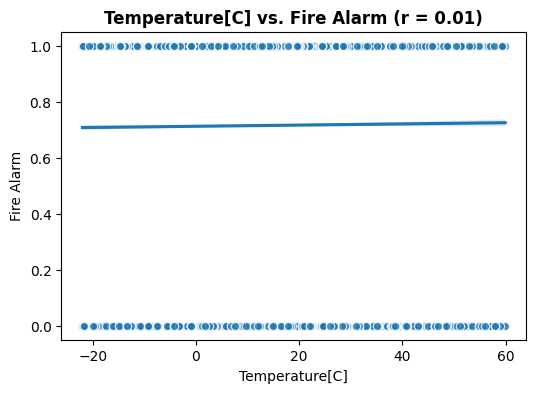

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Temperature[C] vs. Fire Alarm (r = 0.01)'}, xlabel='Temperature[C]', ylabel='Fire Alarm'>)

In [ ]:
feature='Temperature[C]'
target='Fire Alarm'
plot_numeric_vs_target(smoker_df,feature,target)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Raw Ethanol vs. Fire Alarm'}, xlabel='Raw Ethanol', ylabel='Fire Alarm'>)

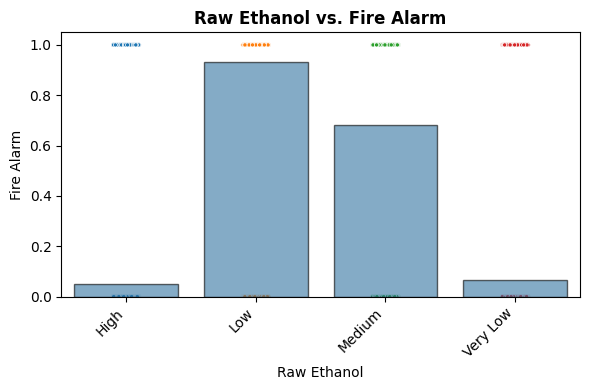

In [ ]:
feature='Raw Ethanol'
plot_categorical_vs_target(smoker_df,feature,target)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Pressure[hPa] vs. eCO2[ppm]'}, xlabel='Pressure[hPa]', ylabel='eCO2[ppm]'>)

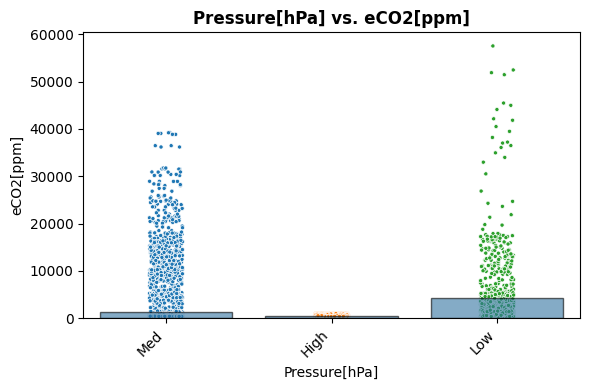

In [ ]:
feature = 'Pressure[hPa]'
target = 'eCO2[ppm]'
plot_categorical_vs_target(smoker_df, feature, target)

## Preproccessing Data

In [ ]:
y=smoker_df['Fire Alarm']
X=smoker_df.drop(columns=['Fire Alarm'])
X_train,X_test,y_train,y_test =train_test_split(X,y,random_state=42)


In [ ]:
# preproccess numaric data
num_cols=X_train.select_dtypes(include='number').columns
impute_median=SimpleImputer(strategy='median')
scaler=StandardScaler()
num_pipe=make_pipeline(impute_median,scaler)
num_tuple=('Numaric',num_pipe,num_cols)

# preproccess categorical data
cat_cols=X_train.select_dtypes(include='object').columns
impute_Na=SimpleImputer(strategy='constant',fill_value='MissingValue')
ords=[['Very Low', 'Low', 'Medium', 'High'], ['Low', 'Med', 'High']]
ord_encoder=OrdinalEncoder(categories=ords)
scaler=StandardScaler()
cat_pipe=make_pipeline(impute_Na,ord_encoder,scaler)
cat_tuple=('Categorical',cat_pipe,cat_cols)

In [ ]:
preproccessor=ColumnTransformer([num_tuple,cat_tuple],verbose_feature_names_out=False)
preproccessor

ColumnTransformer(transformers=[('Numaric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
       'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
      dtype='object')),
                                ('Categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MissingValue',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Very '
                                                                              'Low',
                                                                              'Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Med',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Raw Ethanol', 'Pressure[hPa]'], dtype='object'))],
                  verbose_feature_names_out=False)

### classification Metrices

In [ ]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

In [ ]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

### Decision Tree Classifier


In [ ]:
class_tree=DecisionTreeClassifier(random_state=42)
class_tree_pipe=make_pipeline(preproccessor,class_tree)
class_tree_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numaric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
       'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('simp...
                                                                   SimpleImputer(fill_value='MissingValue',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Very '
                                                                                               'Low',
                                                                                               'Low',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Low',
                                                                                               'Med',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Raw Ethanol', 'Pressure[hPa]'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [ ]:
class_tree_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('Numaric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
          'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
         dtype='object')),
                                   ('Categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='MissingValue',
                                                                   strategy='constant')),
                                                    ('ordinalencoder',
                            

In [ ]:
gird_params={'decisiontreeclassifier__max_depth':[1,2,3,4,5,6,7,8,9,10]}
grid_search_class_tree=GridSearchCV(class_tree_pipe,gird_params,cv=5)
grid_search_class_tree.fit(X_train,y_train)
best_model=grid_search_class_tree.best_estimator_

************************** before grid search**************************
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13438
           1       1.00      1.00      1.00     33536

    accuracy                           1.00     46974
   macro avg       1.00      1.00      1.00     46974
weighted avg       1.00      1.00      1.00     46974



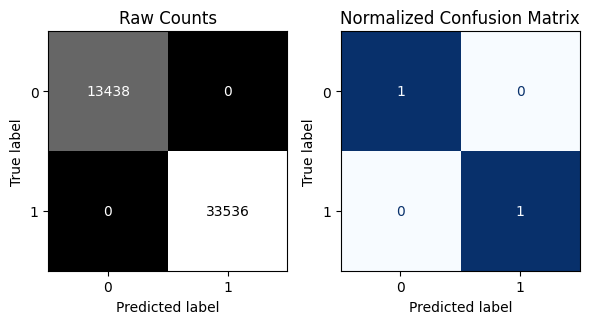


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4438
           1       1.00      1.00      1.00     11221

    accuracy                           1.00     15659
   macro avg       1.00      1.00      1.00     15659
weighted avg       1.00      1.00      1.00     15659



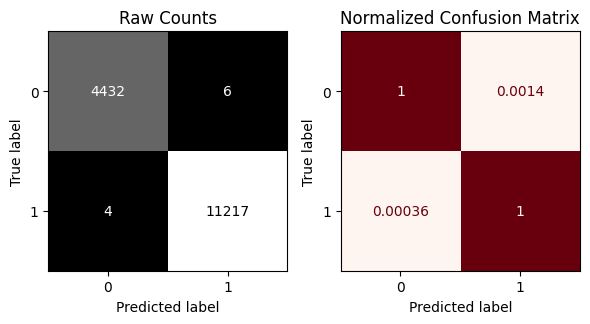


***************************************************************************************************

************************** after grid search**************************
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13438
           1       1.00      1.00      1.00     33536

    accuracy                           1.00     46974
   macro avg       1.00      1.00      1.00     46974
weighted avg       1.00      1.00      1.00     46974



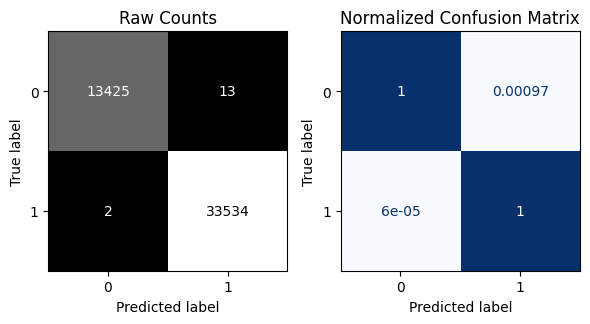


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4438
           1       1.00      1.00      1.00     11221

    accuracy                           1.00     15659
   macro avg       1.00      1.00      1.00     15659
weighted avg       1.00      1.00      1.00     15659



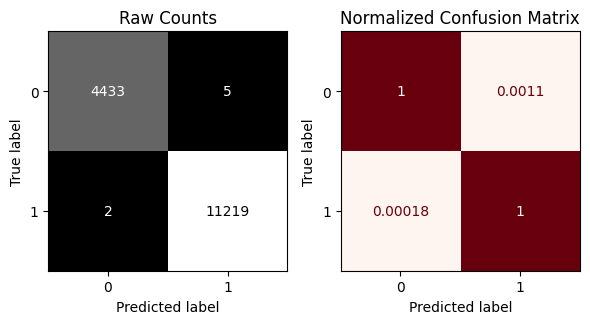

In [ ]:
print('************************** before grid search**************************')
evaluate_classification(class_tree_pipe,X_train,y_train,X_test,y_test)
print('\n***************************************************************************************************\n')
print('************************** after grid search**************************')
evaluate_classification(best_model,X_train,y_train,X_test,y_test)

### Logistic regression


In [ ]:
log_reg=LogisticRegression(random_state=42)
log_reg_pipe=make_pipeline(preproccessor,log_reg)
log_reg_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numaric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
       'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('simp...
                                                                   SimpleImputer(fill_value='MissingValue',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Very '
                                                                                               'Low',
                                                                                               'Low',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Low',
                                                                                               'Med',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Raw Ethanol', 'Pressure[hPa]'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression(random_state=42))])

In [ ]:
log_reg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('Numaric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
          'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
         dtype='object')),
                                   ('Categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='MissingValue',
                                                                   strategy='constant')),
                                                    ('ordinalencoder',
                            

In [ ]:
gird_params={'logisticregression__C':[0.001,0.01,0.1,1,10,100,1000]}
grid_search_log_reg=GridSearchCV(log_reg_pipe,gird_params,cv=5)
grid_search_log_reg.fit(X_train,y_train)
best_model=grid_search_log_reg.best_estimator_

************************** before grid search**************************
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.56      0.69     13438
           1       0.85      0.97      0.91     33536

    accuracy                           0.86     46974
   macro avg       0.87      0.77      0.80     46974
weighted avg       0.86      0.86      0.84     46974



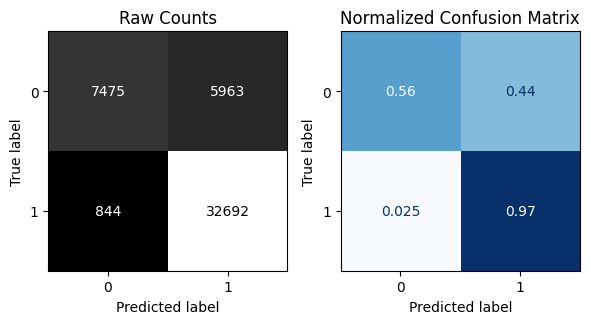


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.58      0.70      4438
           1       0.85      0.98      0.91     11221

    accuracy                           0.86     15659
   macro avg       0.88      0.78      0.81     15659
weighted avg       0.87      0.86      0.85     15659



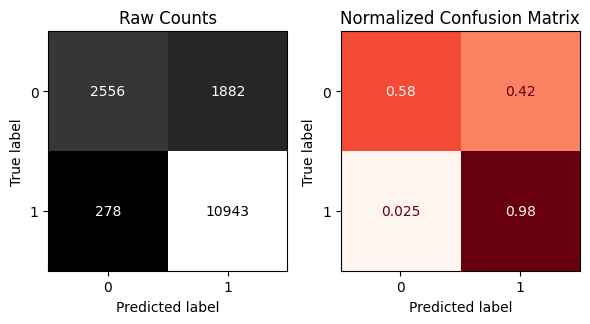


***************************************************************************************************

************************** after grid search**************************
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.56      0.69     13438
           1       0.85      0.97      0.91     33536

    accuracy                           0.86     46974
   macro avg       0.87      0.77      0.80     46974
weighted avg       0.86      0.86      0.84     46974



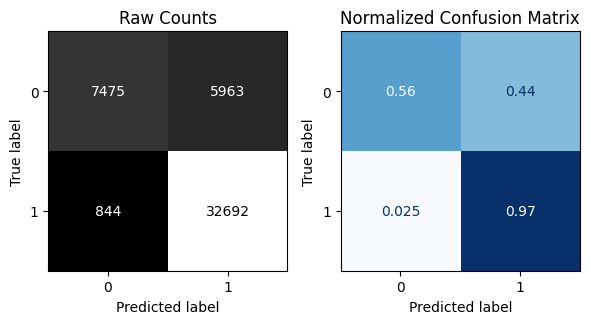


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.58      0.70      4438
           1       0.85      0.98      0.91     11221

    accuracy                           0.86     15659
   macro avg       0.88      0.78      0.81     15659
weighted avg       0.87      0.86      0.85     15659



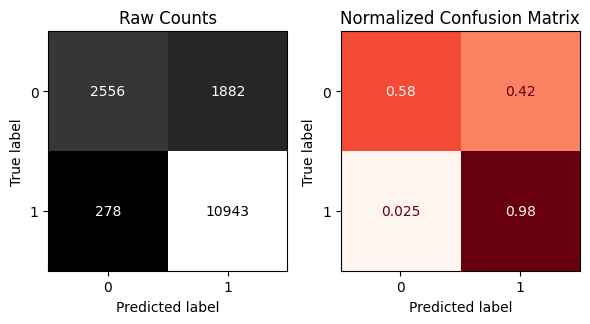

In [ ]:
print('************************** before grid search**************************')
evaluate_classification(log_reg_pipe,X_train,y_train,X_test,y_test)
print('\n***************************************************************************************************\n')
print('************************** after grid search**************************')
evaluate_classification(best_model,X_train,y_train,X_test,y_test)

### Logistic regression


In [ ]:
knn=KNeighborsClassifier()
knn_pipe=make_pipeline(preproccessor,knn)
knn_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numaric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
       'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('simp...puter',
                                                                   SimpleImputer(fill_value='MissingValue',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Very '
                                                                                               'Low',
                                                                                               'Low',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Low',
                                                                                               'Med',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Raw Ethanol', 'Pressure[hPa]'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('Numaric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
          'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
         dtype='object')),
                                   ('Categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='MissingValue',
                                                                   strategy='constant')),
                                                    ('ordinalencoder',
                            

In [ ]:
gird_params={'kneighborsclassifier__n_neighbors':[1,2,3,4,5]}
grid_search_knn=GridSearchCV(knn_pipe,gird_params,cv=5)
grid_search_knn.fit(X_train,y_train)
best_model=grid_search_knn.best_estimator_

************************** before grid search**************************
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     13438
           1       0.92      0.98      0.95     33536

    accuracy                           0.93     46974
   macro avg       0.93      0.88      0.90     46974
weighted avg       0.93      0.93      0.92     46974



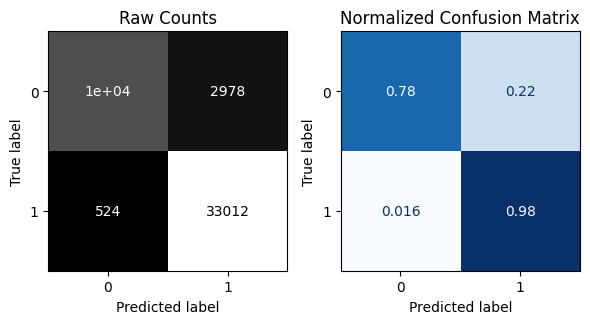


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      4438
           1       0.90      0.97      0.93     11221

    accuracy                           0.90     15659
   macro avg       0.90      0.85      0.87     15659
weighted avg       0.90      0.90      0.89     15659



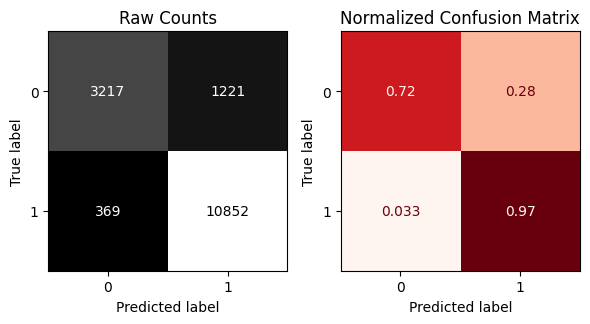


***************************************************************************************************

************************** after grid search**************************
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     13438
           1       0.92      0.98      0.95     33536

    accuracy                           0.93     46974
   macro avg       0.93      0.88      0.90     46974
weighted avg       0.93      0.93      0.92     46974



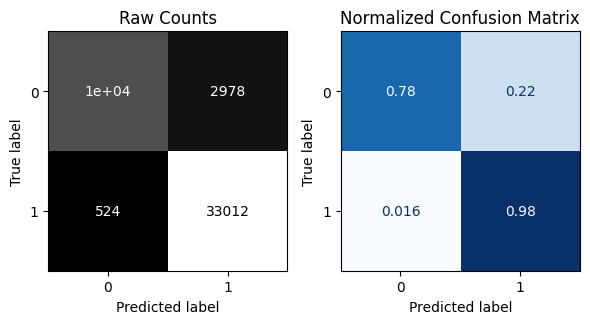


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      4438
           1       0.90      0.97      0.93     11221

    accuracy                           0.90     15659
   macro avg       0.90      0.85      0.87     15659
weighted avg       0.90      0.90      0.89     15659



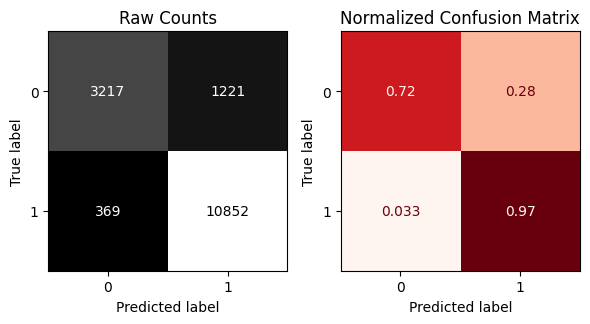

In [ ]:
print('************************** before grid search**************************')
evaluate_classification(knn_pipe,X_train,y_train,X_test,y_test)
print('\n***************************************************************************************************\n')
print('************************** after grid search**************************')
evaluate_classification(best_model,X_train,y_train,X_test,y_test)

still just random forest